<a href="https://colab.research.google.com/github/markefuller/CAP4630/blob/master/HW2/hw2problem1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mark E Fuller
UCF CAP 4630 Fall 2019

**Homework 2 Problem 1:**

Come up with handcrafted features for the MNIST digit classificiation problem and use them in a simple model consisting of a single dense layer with softmax activation.
Let x be the matrix representing a image of a MNIST digit. Let vec(x) denote the flattened matrix x.

Your baseline model is the simple model that takes only vec(x) as input. The goal is to improve the accuracy of the simple model by augmenting the input vec(x) with hand-crafted features.

Say, f1, f2, ..., fm are your hand-crafted features. The augmented input vector is then obtained by stacking vec(x) and the vector (f1, f2, ..., fm). You can use the numpy command np.concatentate to stack vectors.

The features could be:

•	width of digit (normalized to be in the range (0, 1)

•	height of digit (normalized to be in the range (0, 1)

•	number of white regions (a typical 8 has three, a typical 6 has two components, and 2 has 1), average intensity, etc.

•	note the you can one-hot encode the number of connected components as follows: b1 = 1 iff num = 1, b2 = 1 if num = 2, b3 = 1 if num = 3, and b = 1 if num = 0 or num >= 4 (the latter case should normally not occur for well-formed digits); this is probably better than have just a single feature num / 3.

The problem of computing the number of independent white regions is a basic problem for job interviews. It boils down to computing connected components of the following graph. 

The vertices of the graph correspond to the pixels and are denoted by (i, j), which is the position of the pixel. Two vertices (i, j) and (i', j') are connected iff |i - i'| <= 1 and |j - j'| <= 1. If a pixel at position (i, j) is black, then remove it together with its edges.

You have to compute the number of connected components for the 60 thousand images. So make sure that your code is efficient.


# Imports and Data Load

In [0]:
# Packages used
!pip install colorama

from keras.datasets import mnist
from colorama import Fore, Back, Style
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

# Load dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# 1 Recomputes all, 0 loads saved computes from file
# 1 takes about 8 minutes,  0 takes around 30 seconds
recompute = 0

Using TensorFlow backend.


# Functions to Create Hand Features

In [0]:
def print_image(img):
    # Display a Greyscale image as integer values
    for row in range(img.shape[0]):
        for col in range(img.shape[1]):
            if img[row,col] == 0:
                print(Fore.BLACK + Back.RESET + "{0:3d}".format(img[row,col]), end = " ")
            else:
                print(Fore.WHITE + Back.GREEN + "{0:3d}".format(img[row,col]), end = " ")
        print()
    print()

def greyscale_to_binary(img, cutoff):
    # Make copy so as not to modify original passed by reference
    # Greyscale values are 0 to 255 for Keras MNIST digits
    # Values up to cutoff intensity become 0, over cutoff become 1
    imgcopy = img.copy()
    imgcopy[imgcopy <= cutoff] = 0
    imgcopy[imgcopy > cutoff] = 1
    return imgcopy
    
def img_size_intensity(img):
    # Function return 3-tuple of Height, Width, White-Pixel-Count
    # Use binary form for data
    new_img = greyscale_to_binary(img,127)
    rows = new_img.shape[0]
    cols = new_img.shape[1]
    white_count = 0
    minrow = rows
    maxrow = 0
    mincol = cols
    maxcol = 0
    for row in range(rows):
        for col in range(cols):
            if new_img[row,col] == 0:
                white_count += 1
            else:
                if row < minrow:
                    minrow = row
                if row > maxrow:
                    maxrow = row
                if col < mincol:
                    mincol = col
                if col > maxcol:
                    maxcol = col
    height = maxrow - minrow + 1
    width = maxcol - mincol + 1
    new_img = None
    return (height, width, white_count)

# Globals for next functions
new_label = 2
visited = np.zeros((28,28))

def mark_single_region(img, row, col, label):
    # Labels all pixels from starting point that are in same region
    # as starting point
    global new_label
    global visited
    
    # Base Case: Return if indices are out of bounds 
    if (row < 0 or row > (img.shape[0] - 1)  or col < 0 or col > (img.shape[1] - 1) ):
        return
    
    # Base Case: Ignore black pixels of image, but mark as visited
    if img[row,col] == 1:
        visited[row,col] = 1
        return
    
    # Base Case: Ignore already marked pixels 
    if img[row,col] > 1:
        return
    
    # Recusive Case: Mark and visit connected components within this region
    if img[row,col] == 0:
        img[row,col] = label
        visited[row,col] = 1
        # Recurse on cardinal directions if not already done
        if ( (row - 1) >= 0 and visited[row - 1,col]==0):
            mark_single_region(img, row - 1, col, label)
        if( (row + 1) <= (img.shape[0] - 1) and visited[row + 1,col]==0):
            mark_single_region(img, row + 1, col, label)
        if ( (col - 1) >= 0 and visited[row,col - 1]==0):
            mark_single_region(img, row, col - 1, label)
        if( (col + 1) <= (img.shape[1] - 1) and visited[row,col + 1]==0):
            mark_single_region(img, row, col + 1, label)
        new_label = label + 1
    
    # Default Return
    return
    
def number_regions(img):
    # Find the number of whitespace regions in an image
    # Clone image since modifications are needed
    new_img = greyscale_to_binary(img,127)
    
    global new_label
    global visited
    new_label = 2     # Reset Starting marker number. Values 0 and 1 are part of binary image
    visited = np.zeros((28,28)) # Reset visited pixels for current image
    rows = new_img.shape[0]
    cols = new_img.shape[1]
    for r in range(rows):
        for c in range(cols):
            if(visited[r,c]==0): # Make recursive call only if in new region
                mark_single_region(new_img,r,c,new_label)
    new_img = None    # Allow memory to be reclaimed.
    return (new_label - 2)        

# Original Greyscale, Binary Version, Marked Regions Example

In [0]:
# Ind is index of a single image from train_iamges
ind = 5     # Shows Many regions reduced to proper number of 2 regions
#ind = 45417 # Binary version generates too many regions. 8 instead of 2
print("Original Values")
print_image(train_images[ind])

Original Values
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  13  25 100 122   7   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0  33 151 208 252 252 252 146   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0  40 152 244 252 253 224 211 252 232  40   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0  15 152 239 252 252 252 216  31  37 252 252 

In [0]:
# Binary is needed with only values 0 and 1 before finding regions
# Regions get marked with 2, 3, 4, ...
# Total number of regions is highest marking number - 1
new_image = greyscale_to_binary(train_images[ind], 127)
print("Binary Conversion with 0 for Greyscale values < 127 and 1 otherwise")
print_image(new_image)

Binary Conversion with 0 for Greyscale values < 127 and 1 otherwise
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   1   1   1   1   1   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0   0   0   0   0   0   1   1   1   1   1   1   1   1   0   0   0   0   0   0   0   0 
  0   0   0   0   0   0   0 

In [0]:
new_label = 2     # Reset Starting marker number. Values 0 and 1 are part of binary image
visited = np.zeros((28,28)) # Reset visited pixels for current image
rows = new_image.shape[0]
cols = new_image.shape[1]
for r in range(rows):
    for c in range(cols):
        if(visited[r,c]==0): # Make recursive call only if in new region
            mark_single_region(new_image,r,c,new_label)
print()
print("White Regions Marked Starting with Region Marker# = 2")
for row in range(28):
    for col in range(28):
        if new_image[row,col] != 1:
            print(Fore.BLACK + Back.RESET + "{0:3d}".format(new_image[row,col]), end = " ")
        else:
            print(Fore.WHITE + Back.GREEN + "{0:3d}".format(new_image[row,col]), end = " ")
    print()
print()
print("Number White Regions = Highest Marked number(", new_label - 1,") - 1 = ", new_label - 2)


White Regions Marked Starting with Region Marker# = 2
  2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2 
  2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2 
  2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2 
  2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2 
  2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2 
  2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2 
  2   2   2   2   2   2   2   2   2   2   2   2   2   2   1   1   1   1   1   1   2   2   2   2   2   2   2   2 
  2   2   2   2   2   2   2   2   2   2   2   2   1   1   1   1   1   1   1   1   2   2   2   2   2   2   2   2 
  2   2   2   2   2   2   2   2   2   2  

# Calculate Regions, Height, Width, White-Pixel-Count on All Training Images

In [0]:
if(recompute):
    start = time.time()
    qty = len(train_images)
    train_regions = np.zeros((qty,1))
    train_height = np.zeros((qty,1))
    train_width = np.zeros((qty,1))
    train_white_pixels = np.zeros((qty,1))

    for i in range(qty):
        train_regions[i,0] = number_regions(train_images[i])
        (train_height[i,0],train_width[i,0],train_white_pixels[i,0]) = img_size_intensity(train_images[i])
    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Run Time = {:0>2}:{:0>2}:{:05.2f} for {:,d} images\n".format(int(hours),int(minutes),seconds, qty))


# Calculate Regions, Height, Width, White-Pixel-Count on All Testing Images

In [0]:
if(recompute):
    start = time.time()
    qty2 = len(test_images)
    test_regions = np.zeros((qty2,1))
    test_height = np.zeros((qty2,1))
    test_width = np.zeros((qty2,1))
    test_white_pixels = np.zeros((qty2,1))

    for i in range(qty2):
        test_regions[i,0] = number_regions(test_images[i])
        (test_height[i,0],test_width[i,0],test_white_pixels[i,0]) = img_size_intensity(test_images[i])
    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Run Time = {:0>2}:{:0>2}:{:05.2f} for {:,d} images\n".format(int(hours),int(minutes),seconds, qty2))

# Save Values for Repeat Runs

In [0]:
from google.colab import files,drive

drive.mount('/content/drive')
if (recompute):
    np.save('/content/drive/My Drive/Colab Notebooks/CAP4630/HW2/file1.npy', train_regions) 
    np.save('/content/drive/My Drive/Colab Notebooks/CAP4630/HW2/file2.npy', train_height)
    np.save('/content/drive/My Drive/Colab Notebooks/CAP4630/HW2/file3.npy', train_width)
    np.save('/content/drive/My Drive/Colab Notebooks/CAP4630/HW2/file4.npy', train_white_pixels)
    np.save('/content/drive/My Drive/Colab Notebooks/CAP4630/HW2/file5.npy', test_regions) 
    np.save('/content/drive/My Drive/Colab Notebooks/CAP4630/HW2/file6.npy', test_height)
    np.save('/content/drive/My Drive/Colab Notebooks/CAP4630/HW2/file7.npy', test_width)
    np.save('/content/drive/My Drive/Colab Notebooks/CAP4630/HW2/file8.npy', test_white_pixels)  
else:
    train_regions = np.load('/content/drive/My Drive/Colab Notebooks/CAP4630/HW2/file1.npy') 
    train_height = np.load('/content/drive/My Drive/Colab Notebooks/CAP4630/HW2/file2.npy')
    train_width = np.load('/content/drive/My Drive/Colab Notebooks/CAP4630/HW2/file3.npy')
    train_white_pixels = np.load('/content/drive/My Drive/Colab Notebooks/CAP4630/HW2/file4.npy')
    test_regions = np.load('/content/drive/My Drive/Colab Notebooks/CAP4630/HW2/file5.npy') 
    test_height = np.load('/content/drive/My Drive/Colab Notebooks/CAP4630/HW2/file6.npy')
    test_width = np.load('/content/drive/My Drive/Colab Notebooks/CAP4630/HW2/file7.npy')
    test_white_pixels = np.load('/content/drive/My Drive/Colab Notebooks/CAP4630/HW2/file8.npy')    

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Display New Features for First 50 Training Images

In [0]:
print("Hand Features for First 50 Training Images")

for j in range(50):
  print("Index:%05d  Label-%d  Regions-%d  Height-%2d  Width-%2d  White=%3d" %(j, 
    train_labels[j], train_regions[j,0], train_height[j,0], train_width[j,0], train_white_pixels[j,0] ))

Hand Features for First 50 Training Images
Index:00000  Label-5  Regions-1  Height-20  Width-19  White=673
Index:00001  Label-0  Regions-2  Height-20  Width-16  White=659
Index:00002  Label-4  Regions-1  Height-20  Width-19  White=703
Index:00003  Label-1  Regions-1  Height-20  Width-12  White=718
Index:00004  Label-9  Regions-2  Height-20  Width-14  White=693
Index:00005  Label-2  Regions-2  Height-17  Width-20  White=671
Index:00006  Label-1  Regions-1  Height-20  Width- 6  White=717
Index:00007  Label-3  Regions-1  Height-20  Width-17  White=641
Index:00008  Label-1  Regions-1  Height-20  Width- 4  White=739
Index:00009  Label-4  Regions-1  Height-20  Width-18  White=697
Index:00010  Label-3  Regions-1  Height-20  Width-13  White=674
Index:00011  Label-5  Regions-1  Height-14  Width-20  White=725
Index:00012  Label-3  Regions-1  Height-20  Width-20  White=640
Index:00013  Label-6  Regions-2  Height-20  Width-15  White=671
Index:00014  Label-1  Regions-1  Height-20  Width- 4  White=7

# Normalize Hand Features to Between 0 and 1

In [0]:
# Can convert Features to range 0 .. 1 instead of INTs with dividing by Max Size
print("Highest Training Region Count: " , np.amax(train_regions)) 
print("Found at Train_Images[index]: ", np.where(train_regions == np.amax(train_regions))) 
print()

train_regions = train_regions.astype('float32') / np.amax(train_regions)
train_height = train_height.astype('float32') / 28
train_width = train_width.astype('float32') / 28
train_white_pixels = train_white_pixels.astype('float32') / (28 * 28)

print("Normalized Hand Features for First 50 Training Images")
for j in range(50):
  print("Index:%05d  Label-%d  Regions-%.4f  Height-%.4f  Width-%.4f  White=%.4f" %(j, 
    train_labels[j], train_regions[j,0], train_height[j,0], train_width[j,0], train_white_pixels[j,0] ))
  
test_regions = test_regions.astype('float32') / np.amax(test_regions)
test_height = test_height.astype('float32') / 28
test_width = test_width.astype('float32') / 28
test_white_pixels = test_white_pixels.astype('float32') / (28 * 28)


Highest Training Region Count:  8.0
Found at Train_Images[index]:  (array([45417]), array([0]))

Normalized Hand Features for First 50 Training Images
Index:00000  Label-5  Regions-0.1250  Height-0.7143  Width-0.6786  White=0.8584
Index:00001  Label-0  Regions-0.2500  Height-0.7143  Width-0.5714  White=0.8406
Index:00002  Label-4  Regions-0.1250  Height-0.7143  Width-0.6786  White=0.8967
Index:00003  Label-1  Regions-0.1250  Height-0.7143  Width-0.4286  White=0.9158
Index:00004  Label-9  Regions-0.2500  Height-0.7143  Width-0.5000  White=0.8839
Index:00005  Label-2  Regions-0.2500  Height-0.6071  Width-0.7143  White=0.8559
Index:00006  Label-1  Regions-0.1250  Height-0.7143  Width-0.2143  White=0.9145
Index:00007  Label-3  Regions-0.1250  Height-0.7143  Width-0.6071  White=0.8176
Index:00008  Label-1  Regions-0.1250  Height-0.7143  Width-0.1429  White=0.9426
Index:00009  Label-4  Regions-0.1250  Height-0.7143  Width-0.6429  White=0.8890
Index:00010  Label-3  Regions-0.1250  Height-0.71

In [0]:
train_height.shape

(60000, 1)

# Prepare image data for Classification with Dense Layers

In [0]:
train_images_new = train_images.reshape((60000, 28 * 28))
train_images_new = train_images_new.astype('float32') / 255

test_images_new = test_images.reshape((10000, 28 * 28))
test_images_new = test_images_new.astype('float32') / 255

print("train_images_new.shape: ", train_images_new.shape)
print("test_images_new.shape: ", test_images_new.shape)

train_images_new.shape:  (60000, 784)
test_images_new.shape:  (10000, 784)


# Add the 4 Hand Crafted Features

In [0]:
train_images_new = np.concatenate((train_images_new,train_regions), axis = 1)
train_images_new = np.concatenate((train_images_new,train_height), axis = 1)
train_images_new = np.concatenate((train_images_new,train_width), axis = 1)
train_images_new = np.concatenate((train_images_new,train_white_pixels), axis = 1)

test_images_new = np.concatenate((test_images_new,test_regions), axis = 1)
test_images_new = np.concatenate((test_images_new,test_height), axis = 1)
test_images_new = np.concatenate((test_images_new,test_width), axis = 1)
test_images_new = np.concatenate((test_images_new,test_white_pixels), axis = 1)
print("train_images_new.shape: ", train_images_new.shape)
print("test_images_new.shape: ", test_images_new.shape)

train_images_new.shape:  (60000, 788)
test_images_new.shape:  (10000, 788)


# Preparing the Labels

In [0]:
from keras.utils import to_categorical

train_labels_new = to_categorical(train_labels)
test_labels_new = to_categorical(test_labels)

# Diplaying some of the original and prepared image data and labels

In [0]:
train_images_new.shape

(60000, 788)

In [0]:
train_images.shape

(60000, 28, 28)

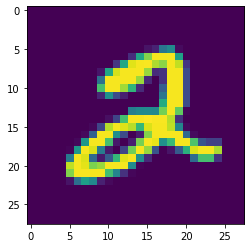

In [0]:
import matplotlib.pyplot as plt
plt.imshow(train_images[ind])
plt.show()

In [0]:
train_labels_new.shape

(60000, 10)

In [0]:
train_labels_new[ind]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [0]:
np.argmax(train_labels_new[ind])

2

In [0]:
train_labels[ind]

2

# The Network Architecture

In [0]:
from keras import models
from keras import layers

# HW Instructions limit to single dense layer followed bu softmax
network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(788,)))
network.add(layers.Dense(10, activation='softmax'))
network.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               403968    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 409,098
Trainable params: 409,098
Non-trainable params: 0
_________________________________________________________________


# The Compilation Step

In [0]:
network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# The Training Step

In [0]:
epochs = 10
history = network.fit(train_images_new, 
                      train_labels_new, 
                      epochs=epochs, 
                      batch_size=128, 
                      validation_data=(test_images_new, test_labels_new))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 60000 samples, validate on 10000 samples
Epoch 1/10





60000/60000 [==============================] - 3s 52us/step - loss: 0.2527 - acc: 0.9271 - val_loss: 0.1273 - val_acc: 0.9609
Epoch 2/10
60000/60000 [==============================] - 2s 39us/step - loss: 0.0992 - acc: 0.9705 - val_loss: 0.0789 - val_acc: 0.9753
Epoch 3/10
60000/60000 [==============================] - 2s 39us/step - loss: 0.0651 - acc: 0.9802 - val_loss: 0.0711 - val_acc: 0.9778
Epoch 4/10
60000/60000 [==============================] - 2s 39us/step - loss: 0.0473 - acc: 0.9853 - val_loss: 0.0702 - val_acc: 0.9783
Epoch 5/10
60000/60000 [==============================] - 2s 38us/step - loss: 0.0358 - acc: 0.9896 - val_loss: 0.0584 - val_acc: 0.9822
Epoch 6/10
60000/60000 [==============================] - 2s 37us/step - loss: 0.0270 - acc: 0.9916 - val_loss: 0.0557 - val_acc: 0.9829
Epoch 7/10
60000/60000 [==

# Display the training/test loss/accuracy

In [0]:
history_dict = history.history
loss_values = history_dict['loss']
test_loss_values = history_dict['val_loss']
epochs_range = range(1, epochs + 1)

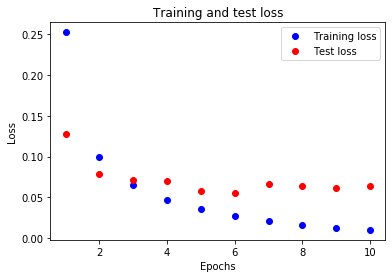

In [0]:
plt.plot(epochs_range, loss_values, 'bo', label='Training loss')
plt.plot(epochs_range, test_loss_values, 'ro', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
acc_values = history_dict['acc']
test_acc_values = history_dict['val_acc']

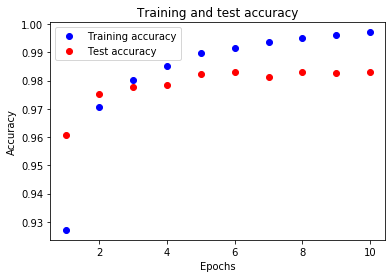

In [0]:
plt.plot(epochs_range, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs_range, test_acc_values, 'ro', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Overfitting

As you can see, the training loss decreases with every epoch, and the training accuracy increases with every epoch. That's what you would expect when gradient descent optimization - the quantity you're trying to minimize should be less with every iteration.

But this isn't the case for the training loss and accuracy: they seem to peak at the third epoch.

This is an example of overfitting: a model that performs better on the training data isn't necessarily a model that performs better on data it has never seen before. You are overoptimizing on the training data, and you end up learning representations that are specific to the training data and don't generalize to data outside the training set.